<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/05_VAR_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAR Backtesting in R (Colab-ready)

Full-sample (final fit), Fixed-origin (holdout), Rolling-origin + Rolling window, Rolling-origin + Expanding window

**Notes**
- Uses daily adjusted prices for `TSLA` and `SPY` (you can change symbols).
- Works on **log-returns** to promote stationarity in VAR.
- Forecasts **returns**, then reconstructs TSLA **price path** for plots.


In [1]:
# ============================
# 0) Setup (packages & options)
# ============================
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)  # display size in Colab
suppressPackageStartupMessages({
  pkgs <- c(
    "quantmod","vars","tseries","urca","xts","zoo",
    "ggplot2","dplyr","tidyr","tibble","scales","glue","magrittr"
  )
  new <- pkgs[!(pkgs %in% installed.packages()[, "Package"])]
  if (length(new)) install.packages(new, repos = "https://cloud.r-project.org")
  invisible(lapply(pkgs, library, character.only = TRUE))
})
theme_set(theme_minimal(base_size = 13))
set.seed(42)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TTR’, ‘strucchange’, ‘lmtest’, ‘sandwich’, ‘quadprog’




In [2]:
# ============================
# 1) Data (download & returns)
# ============================
symbols <- c("TSLA", "SPY")   # you may edit this list
from    <- "2022-01-01"
to      <- "2024-01-01"

suppressMessages(getSymbols(symbols, src = "yahoo", from = from, to = to, auto.assign = TRUE))

# Adjusted close merged into one xts
px_list <- lapply(symbols, function(sym) Ad(get(sym)))
px <- do.call(merge, px_list)
colnames(px) <- symbols
px <- na.locf(px)
px <- na.omit(px)

# Log-returns (%)
ret <- diff(log(px)) * 100
ret <- na.omit(ret)

n <- nrow(ret)
split <- floor(n * 0.8)
ret_train <- ret[1:split,]
ret_test  <- ret[(split+1):n,]
dates_train <- index(ret_train)
dates_test  <- index(ret_test)

# TSLA prices for overlay
p_tsla <- px[, "TSLA"]
p_train_end <- as.numeric(last(p_tsla[index(p_tsla) <= tail(dates_train, 1)]))
p_test_actual <- as.numeric(p_tsla[index(p_tsla) %in% dates_test])

cat(glue::glue("Rows (returns): total={n}, train={nrow(ret_train)}, test={nrow(ret_test)}\n"))


[1] "TSLA" "SPY"

Rows (returns): total=500, train=400, test=100

In [3]:
# ============================
# 2) Helpers (metrics & utils)
# ============================
rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
r2   <- function(a, b) {
  ss_res <- sum((a - b)^2, na.rm = TRUE)
  ss_tot <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res/ss_tot
}

to_price_path <- function(p0, returns_pct) {
  out <- numeric(length(returns_pct))
  prev <- p0
  for (i in seq_along(returns_pct)) {
    prev <- prev * exp(returns_pct[i]/100)
    out[i] <- prev
  }
  out
}

fit_var_safe <- function(y_df, p) {
  tryCatch({ vars::VAR(y_df, p = p, type = "const") }, error = function(e) NULL)
}

select_lag_aic <- function(y_df, lag_max = 5L) {
  sel <- tryCatch(vars::VARselect(y_df, lag.max = lag_max, type = "const"), error = function(e) NULL)
  if (is.null(sel)) return(1L)
  p <- sel$selection[["AIC(n)"]]
  if (is.na(p) || p < 1) p <- 1L
  as.integer(p)
}

one_step_forecast_var <- function(y_df, p) {
  fit <- fit_var_safe(y_df, p)
  if (is.null(fit)) {
    return(as.numeric(tail(y_df$TSLA, 1)))  # naive fallback: last TSLA return
  }
  pr <- predict(fit, n.ahead = 1)
  as.numeric(pr$fcst$TSLA[1, "fcst"])  # 1-step TSLA return forecast
}


In [4]:
# ============================
# 3) Hyperparameters
# ============================
LAG_MAX <- 5L      # max VAR lag for selection
W       <- 120L    # rolling window length
stride  <- 10L     # how often to reselect lag (0 = no reselection)
h       <- 20L     # horizon for full-sample future forecast (days)


## A) Full-sample (final fit)
- Fit VAR on the **entire** return series (TSLA, SPY) and forecast **h**-step ahead returns.
- Not for backtesting (data leakage), but good for a final model fit.


[Full] chosen lag p=4

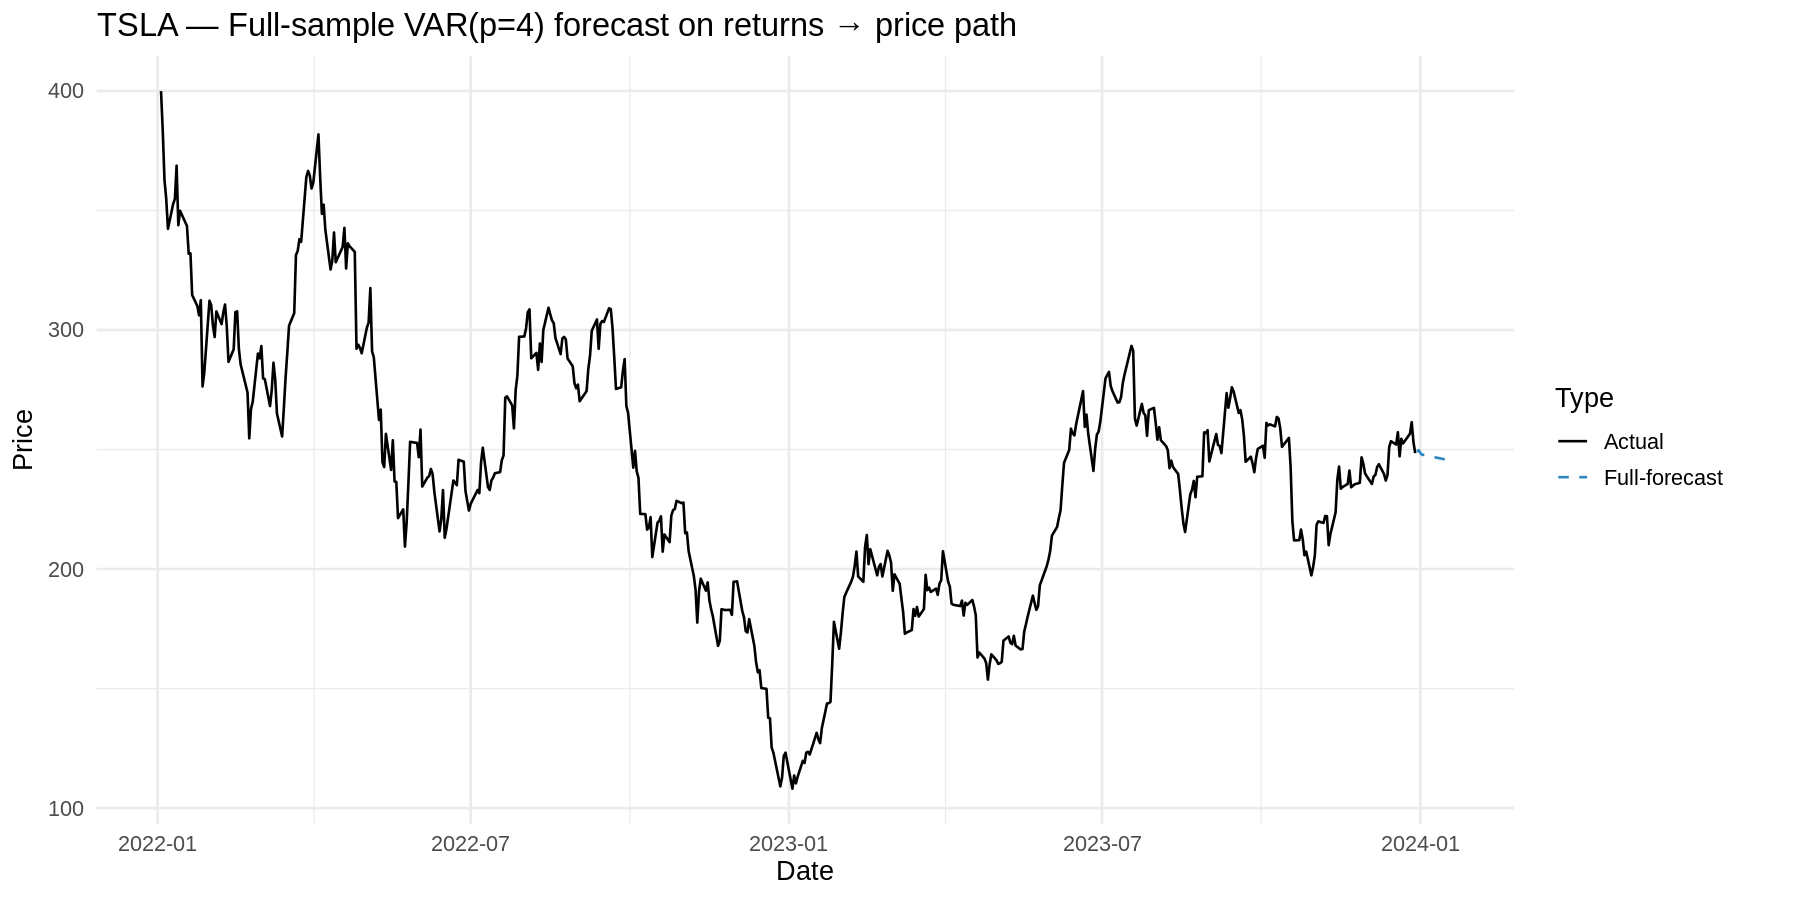

In [5]:
y_full_df <- as.data.frame(ret)
p_full <- select_lag_aic(y_full_df, lag_max = LAG_MAX)
fit_full <- fit_var_safe(y_full_df, p_full)
cat(glue::glue("[Full] chosen lag p={p_full}\n"))

ret_fc_full <- if (!is.null(fit_full)) as.numeric(predict(fit_full, n.ahead = h)$fcst$TSLA[,"fcst"]) else rep(0, h)
p0 <- as.numeric(last(p_tsla))
px_fc_full <- to_price_path(p0, ret_fc_full)

future_dates <- seq(from = tail(index(px), 1) + 1, by = "days", length.out = h)

df_full <- tibble::tibble(
  Date = c(index(px), future_dates),
  Price = c(as.numeric(px$TSLA), px_fc_full),
  Type = c(rep("Actual", nrow(px)), rep("Full-forecast", h))
)

ggplot(df_full, aes(Date, Price, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c("Actual" = "black", "Full-forecast" = "#2E86C1")) +
  scale_linetype_manual(values = c("Actual" = "solid", "Full-forecast" = "dashed")) +
  labs(title = glue::glue("TSLA — Full-sample VAR(p={p_full}) forecast on returns → price path"),
       x = "Date", y = "Price")


## B) Fixed-origin (holdout, static parameters)
- Fit VAR **once** on the training returns.
- Forecast the **entire** test period at once (multi-step).

[Fixed-origin] chosen lag p=2[Fixed-origin] RMSE=2.9877 | MAE=2.2317 | R2=-0.0027

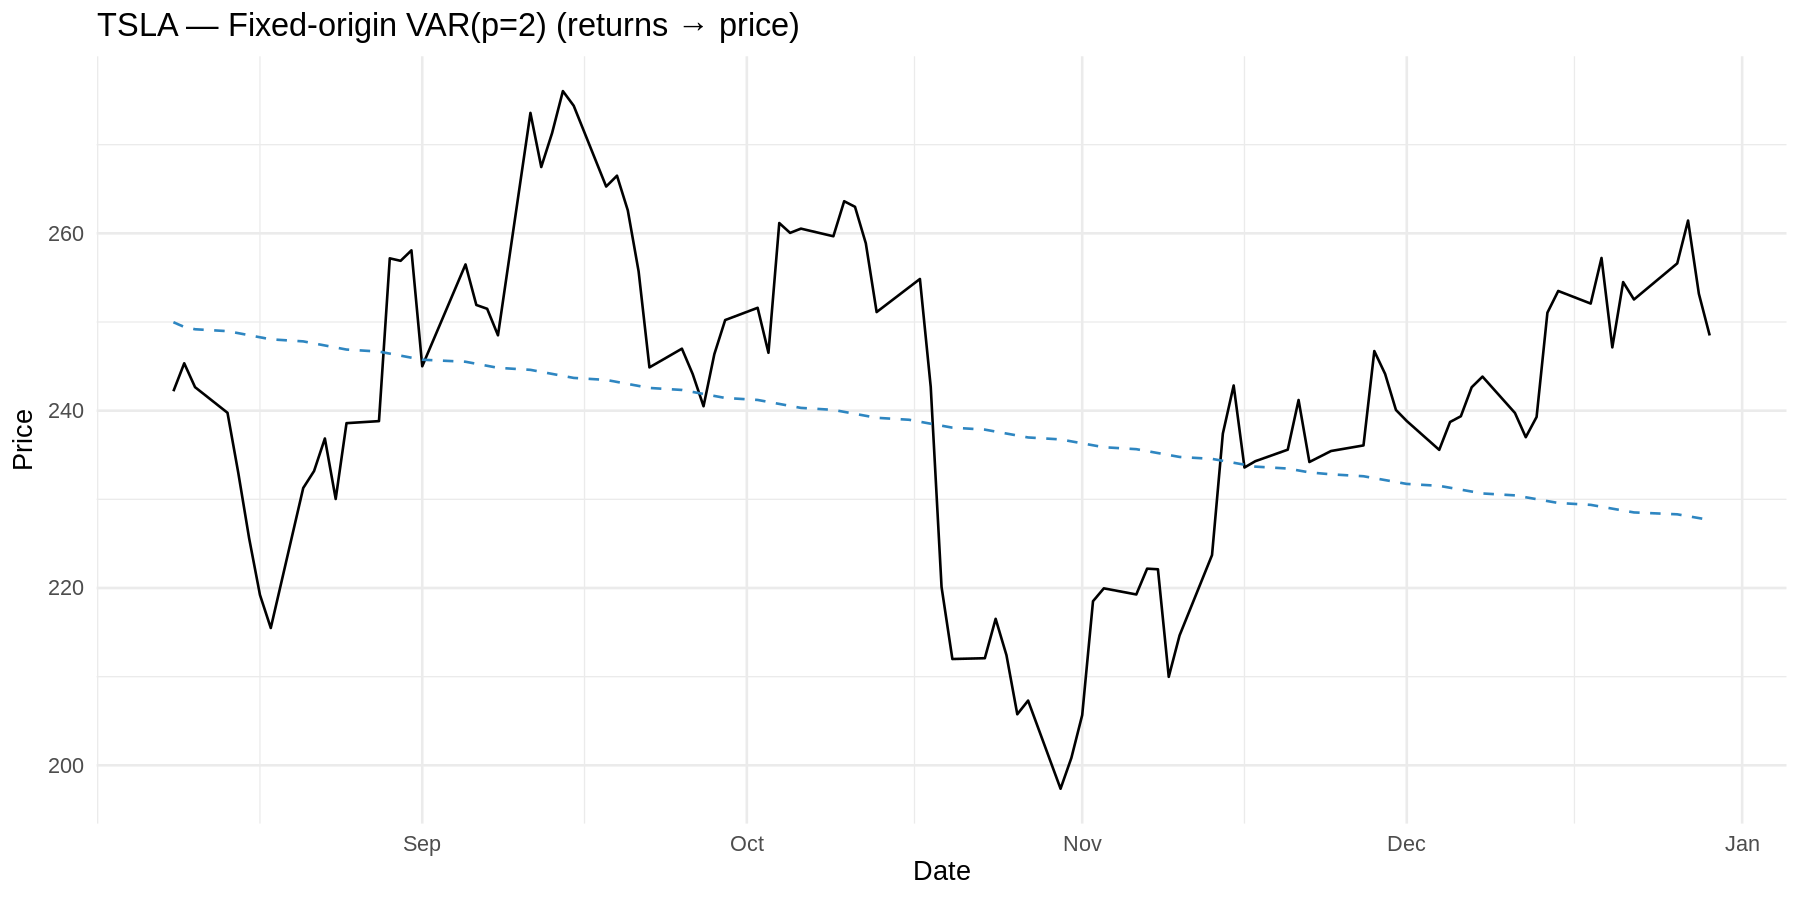

In [6]:
y_train_df <- as.data.frame(ret_train)
y_test_df  <- as.data.frame(ret_test)
p_fix <- select_lag_aic(y_train_df, lag_max = LAG_MAX)
fit_fix <- fit_var_safe(y_train_df, p_fix)
cat(glue::glue("[Fixed-origin] chosen lag p={p_fix}\n"))

ret_pred_fix <- if (!is.null(fit_fix)) as.numeric(predict(fit_fix, n.ahead = nrow(y_test_df))$fcst$TSLA[,"fcst"]) else rep(0, nrow(y_test_df))

y_test_tsla <- as.numeric(ret_test$TSLA)
rmse_fix <- rmse(y_test_tsla, ret_pred_fix)
mae_fix  <- mae(y_test_tsla, ret_pred_fix)
r2_fix   <- r2(y_test_tsla, ret_pred_fix)
cat(glue::glue("[Fixed-origin] RMSE={round(rmse_fix,4)} | MAE={round(mae_fix,4)} | R2={round(r2_fix,4)}\n"))

px_fix <- to_price_path(p_train_end, ret_pred_fix)
df_fix <- tibble::tibble(Date = dates_test, Actual = p_test_actual, Pred = px_fix)

ggplot(df_fix, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "#2E86C1", linetype = "dashed") +
  labs(title = glue::glue("TSLA — Fixed-origin VAR(p={p_fix}) (returns → price)"),
       x = "Date", y = "Price")


## C) Rolling-origin + Rolling window
- Use a **fixed-length** window `W` of the most recent data.
- At each test step, re-fit and make a **1-step** forecast.
- Optionally re-select lag every `stride` steps.

[Rolling window] RMSE=2.9295 | MAE=2.1972 | R2=0.036

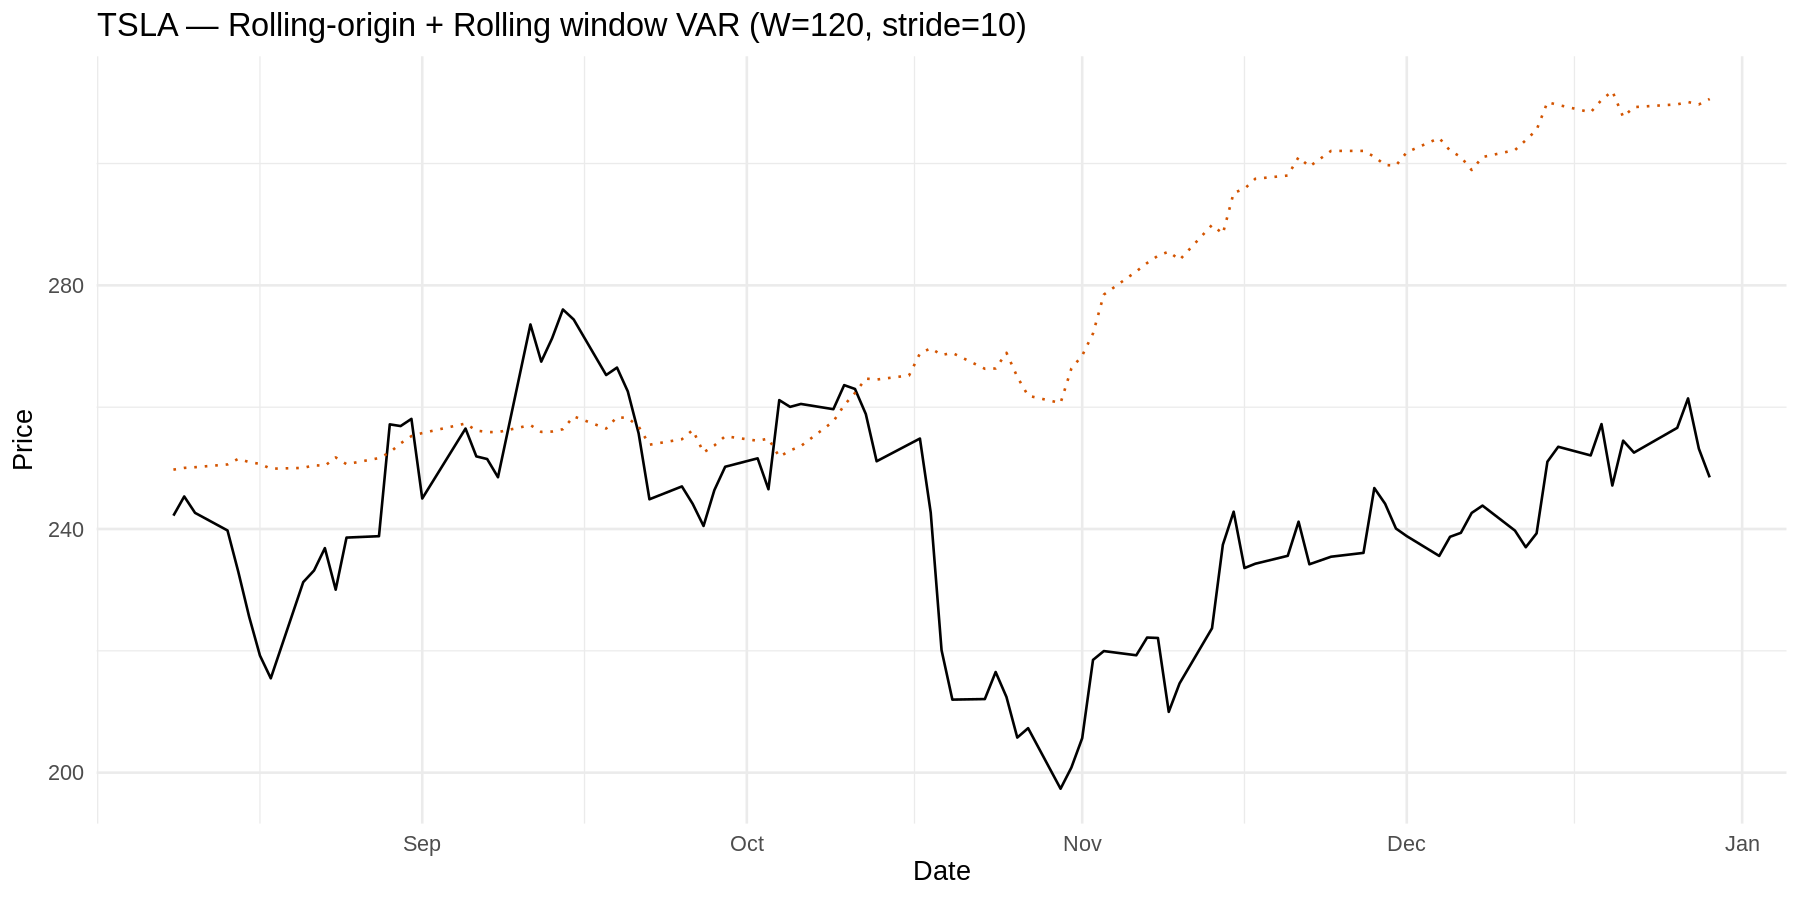

In [7]:
ret_pred_roll <- rep(NA_real_, nrow(ret_test))
hist <- ret_train

# initial selection from the last W of train
y_init <- as.data.frame(tail(hist, min(W, nrow(hist))))
current_p <- select_lag_aic(y_init, lag_max = LAG_MAX)
for (i in seq_len(nrow(ret_test))) {
  y_win <- as.data.frame(tail(hist, min(W, nrow(hist))))
  if (stride > 0 && ((i - 1) %% stride) == 0) {
    current_p <- select_lag_aic(y_win, lag_max = LAG_MAX)
  }
  ret_pred_roll[i] <- one_step_forecast_var(y_win, current_p)
  hist <- rbind(hist, ret_test[i,])  # walk-forward with actual
}

y_test_tsla <- as.numeric(ret_test$TSLA)
rmse_r <- rmse(y_test_tsla, ret_pred_roll)
mae_r  <- mae(y_test_tsla, ret_pred_roll)
r2_r   <- r2(y_test_tsla, ret_pred_roll)
cat(glue::glue("[Rolling window] RMSE={round(rmse_r,4)} | MAE={round(mae_r,4)} | R2={round(r2_r,4)}\n"))

px_roll <- to_price_path(p_train_end, ret_pred_roll)
df_roll <- tibble::tibble(Date = dates_test, Actual = p_test_actual, Pred = px_roll)

ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "#D35400", linetype = "dotted") +
  labs(title = glue::glue("TSLA — Rolling-origin + Rolling window VAR (W={W}, stride={stride})"),
       x = "Date", y = "Price")


## D) Rolling-origin + Expanding window (Recursive)
- Use a **growing** window (all data seen so far).
- At each test step, re-fit and make a **1-step** forecast.
- Optionally re-select lag every `stride` steps.

[Expanding window] RMSE=2.9648 | MAE=2.1949 | R2=0.0126# A tibble: 3 × 4
  Method            RMSE   MAE       R2
  <chr>            <dbl> <dbl>    <dbl>
1 Rolling window    2.93  2.20  0.0360 
2 Expanding window  2.96  2.19  0.0126 
3 Fixed-origin      2.99  2.23 -0.00266


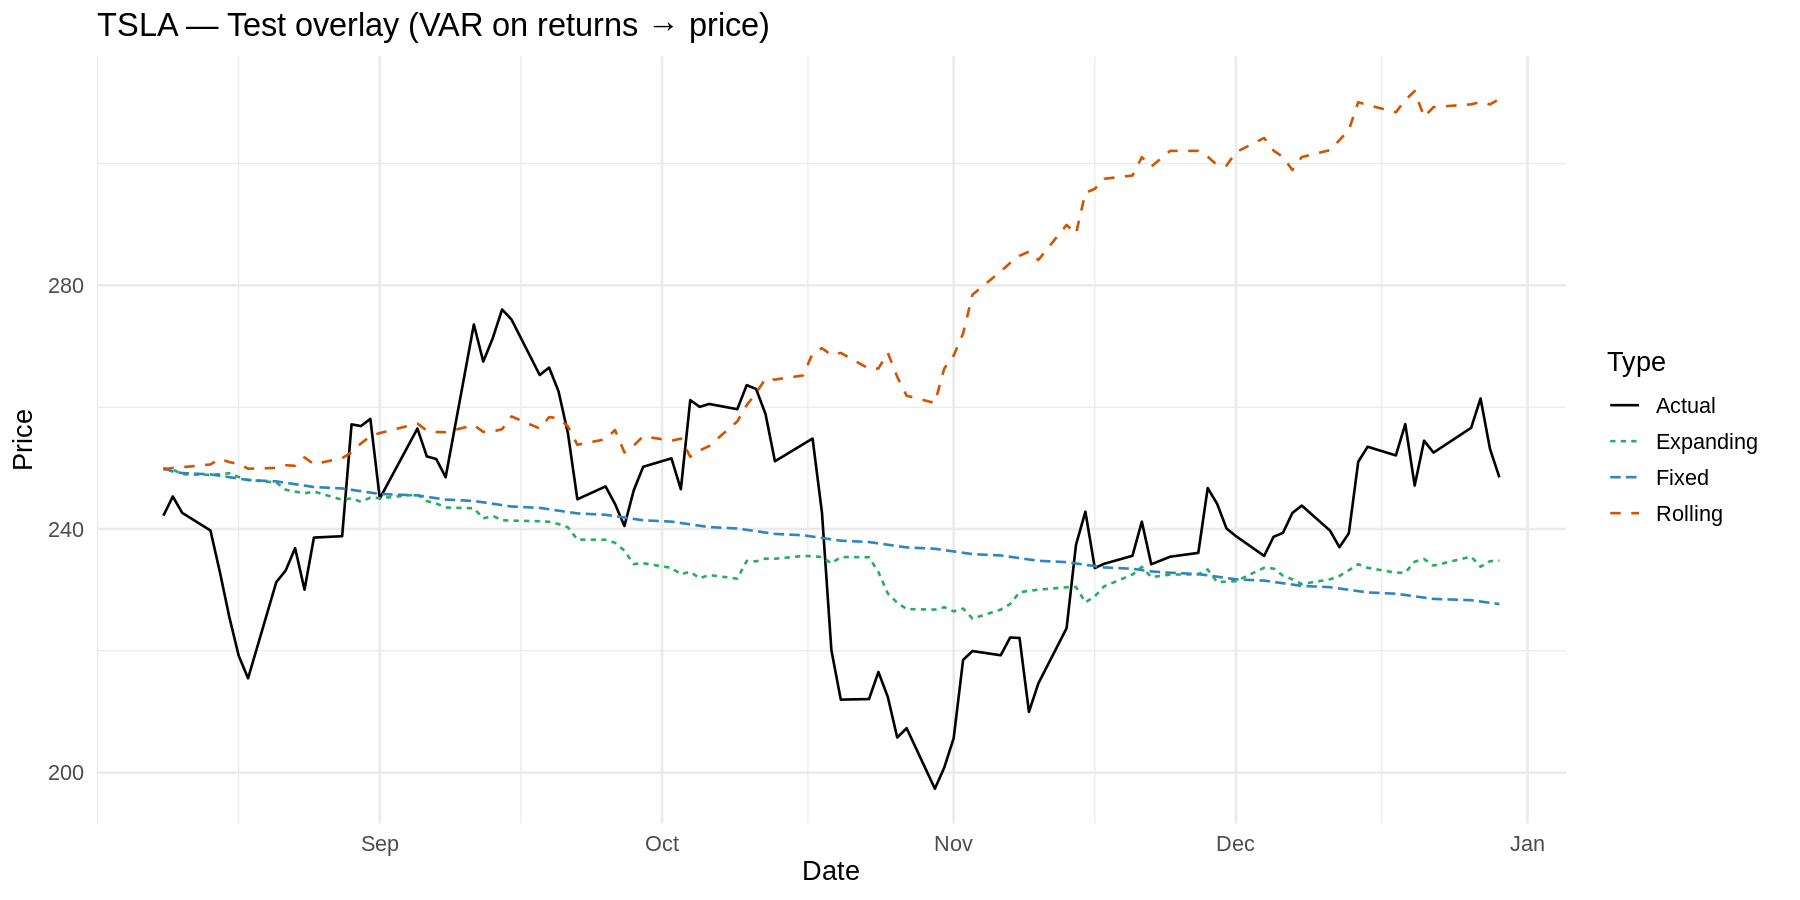

In [8]:
ret_pred_exp <- rep(NA_real_, nrow(ret_test))
hist <- ret_train
current_p <- select_lag_aic(as.data.frame(hist), lag_max = LAG_MAX)
for (i in seq_len(nrow(ret_test))) {
  if (stride > 0 && ((i - 1) %% stride) == 0) {
    current_p <- select_lag_aic(as.data.frame(hist), lag_max = LAG_MAX)
  }
  ret_pred_exp[i] <- one_step_forecast_var(as.data.frame(hist), current_p)
  hist <- rbind(hist, ret_test[i,])
}

y_test_tsla <- as.numeric(ret_test$TSLA)
rmse_e <- rmse(y_test_tsla, ret_pred_exp)
mae_e  <- mae(y_test_tsla, ret_pred_exp)
r2_e   <- r2(y_test_tsla, ret_pred_exp)
cat(glue::glue("[Expanding window] RMSE={round(rmse_e,4)} | MAE={round(mae_e,4)} | R2={round(r2_e,4)}\n"))

px_exp <- to_price_path(p_train_end, ret_pred_exp)

# Overlay: Actual vs 3 methods
df_overlay <- tibble::tibble(
  Date = dates_test,
  Actual = p_test_actual,
  Fixed = px_fix,
  Rolling = px_roll,
  Expanding = px_exp
) %>% tidyr::pivot_longer(-Date, names_to = "Type", values_to = "Price")

ggplot(df_overlay, aes(Date, Price, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c(
    "Actual" = "black", "Fixed" = "#2E86C1", "Rolling" = "#D35400", "Expanding" = "#27AE60"
  )) +
  labs(title = "TSLA — Test overlay (VAR on returns → price)", x = "Date", y = "Price")

summary_tbl <- tibble::tibble(
  Method = c("Fixed-origin", "Rolling window", "Expanding window"),
  RMSE   = c(rmse_fix, rmse_r, rmse_e),
  MAE    = c(mae_fix,  mae_r,  mae_e),
  R2     = c(r2_fix,   r2_r,   r2_e)
) %>% arrange(RMSE)
print(summary_tbl)
